In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
import re

# Define the regular expression pattern that matches the separator between values
pattern = r'\s+'

In [91]:
df = pd.read_csv("Vertebral_column_3C.dat", header=None, names=['pelvic incidence','pelvic tilt',
           ' lumbar lordosis angle',' sacral slope',
           'pelvic radius', ' grade of spondylolisthesis', 
           'Class label'], sep=pattern)

In [92]:
df.head()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis,Class label
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH


In [93]:
y=df['Class label']

In [94]:
x = df.drop(df.columns[6], axis=1)

In [95]:
df.shape

(310, 7)

In [96]:
mapping = {'DH': 0, 'NO': 1, 'SL': 2}

# Use the map method to replace the original class labels with the desired labels
y=y.map(mapping)

In [97]:
#split data into a training set (70%) and a testing set (30%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=1,stratify=y)
#Using such a fixed random_state ensures that our results are reproducible.

In [86]:
#stratify=y enables stratification: returns training and test subsets that have the
#same proportions of class labels as the input dataset.

print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [ 60 100 150]
Labels counts in y_train: [ 42  70 105]
Labels counts in y_test: [18 30 45]


In [98]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn

X_train_norm = (X_train.values - np.mean(X_train.values)) / np.std(X_train.values)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train.values)

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [99]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)  
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)  
        self.layer3 = nn.Linear(hidden_size2, output_size)   

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.Softmax(dim=1)(x)
        return x
    
input_size = X_train_norm.shape[1]
hidden_size1 = 10
hidden_size2 = 7
output_size = 3
 
model = Model(input_size, hidden_size1, hidden_size2, output_size)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [100]:
num_epochs = 100
loss_hist = [0] * num_epochs
error_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy = is_correct.sum() / y_batch.size(0)
        error_hist[epoch] += (1 - accuracy)
        
    loss_hist[epoch] /= len(train_dl.dataset)
    error_hist[epoch] /= len(train_dl.dataset)

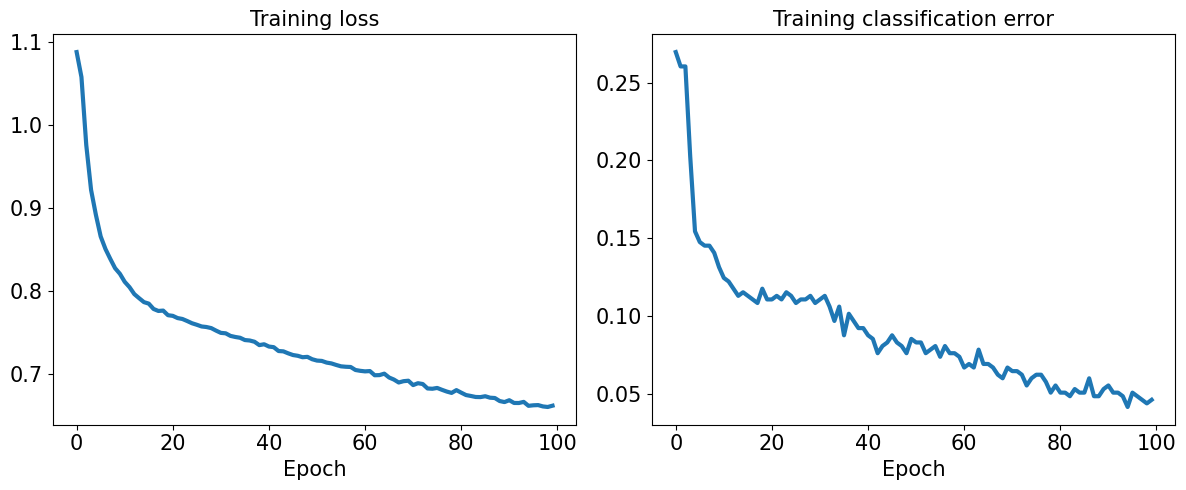

In [101]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(error_hist, lw=3)
ax.set_title('Training classification error', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

plt.show()

In [102]:
X_test_norm = (X_test.values - np.mean(X_train.values)) / np.std(X_train.values)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test.values) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.8065


In [103]:
from sklearn.metrics import confusion_matrix

pred_labels = torch.argmax(pred_test, dim=1)
conf_mat = confusion_matrix(y_test, pred_labels)
class_err = 1 - accuracy

# Print results
print(f'Test Acc.: {accuracy:.4f}')
print(f'Classification Error: {class_err:.4f}')
print(f'Confusion Matrix:\n{conf_mat}')

Test Acc.: 0.8065
Classification Error: 0.1935
Confusion Matrix:
[[10  8  0]
 [ 8 22  0]
 [ 1  1 43]]
